In [1]:
%pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.5 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
print("hello")

hello


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GraphSAGE, global_mean_pool


In [4]:
THREAT_PATH = "/kaggle/input/datasets/saranvigneshpr/certr4-2-threat-output/insider_4_2_final.csv"
threats = pd.read_csv(THREAT_PATH)
threats["user"] = threats["user"].str.strip()
threats["start"] = pd.to_datetime(threats["start"])
threats["end"]   = pd.to_datetime(threats["end"])

threats.head()



,details,user,start,end,label,what type of threat
0,r4.2-1-AAM0658.csv,AAM0658,2010-10-23 01:34:19,2010-10-29 05:23:28,1,Data Exfiltration
1,r4.2-1-AJR0932.csv,AJR0932,2010-09-10 19:12:01,2010-09-18 02:02:51,1,Data Exfiltration
2,r4.2-1-BDV0168.csv,BDV0168,2010-07-30 19:56:44,2010-08-10 05:16:41,1,Data Exfiltration
3,r4.2-1-BIH0745.csv,BIH0745,2010-07-13 20:15:23,2010-07-13 21:20:44,1,Data Exfiltration
4,r4.2-1-BLS0678.csv,BLS0678,2010-09-21 01:16:22,2010-09-30 04:48:19,1,Data Exfiltration


In [5]:
# =========================
# 1. Load & Clean
# =========================
BASE = "/kaggle/input/certr42/r4.2"


def load_csv(name):
    df = pd.read_csv(f"{BASE}/{name}.csv")
    df.columns = df.columns.str.lower()
    df["user"] = df["user"].str.strip()
    df["date"] = pd.to_datetime(df["date"])
    return df

logon  = load_csv("logon")
print("over ......")
file   = load_csv("file")
print("over ......")
email  = load_csv("email")
print("over ......")

device = load_csv("device")


def basic_analysis(df, name):
    print(f"\n{name.upper()} DATASET")
    print("Shape:", df.shape)
    print("\nColumns:")
    print(df.columns.tolist())
    print("\nMissing values:")
    print(df.isnull().sum())





over ......
over ......
over ......


In [6]:
http   = load_csv("http")
print("over ......")

over ......


In [7]:
threats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   details              70 non-null     object        
 1   user                 70 non-null     object        
 2   start                70 non-null     datetime64[ns]
 3   end                  70 non-null     datetime64[ns]
 4   label                70 non-null     int64         
 5   what type of threat  70 non-null     object        
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 3.4+ KB


# DATA ANALYSYS

In [8]:
def basic_analysis(df, name):
    print(f"\n{'='*40}")
    print(f"{name.upper()} DATASET")
    print(f"{'='*40}")
    print("Shape:", df.shape)
    print("\nColumns:")
    for col in df.columns:
        print(f" - {col} ({df[col].dtype})")
    print("\nMissing values:")
    display(df.isnull().sum().to_frame("missing_count"))


In [9]:
for d, n in zip([logon, file, email, http, device],
                ["logon", "file", "email", "http", "device"]):
    basic_analysis(d, n)



LOGON DATASET
Shape: (854859, 5)

Columns:
 - id (object)
 - date (datetime64[ns])
 - user (object)
 - pc (object)
 - activity (object)

Missing values:


,missing_count
id,0
date,0
user,0
pc,0
activity,0



FILE DATASET
Shape: (445581, 6)

Columns:
 - id (object)
 - date (datetime64[ns])
 - user (object)
 - pc (object)
 - filename (object)
 - content (object)

Missing values:


,missing_count
id,0
date,0
user,0
pc,0
filename,0
content,0



EMAIL DATASET
Shape: (2629979, 11)

Columns:
 - id (object)
 - date (datetime64[ns])
 - user (object)
 - pc (object)
 - to (object)
 - cc (object)
 - bcc (object)
 - from (object)
 - size (int64)
 - attachments (int64)
 - content (object)

Missing values:


,missing_count
id,0
date,0
user,0
pc,0
to,0
cc,1617054
bcc,2212977
from,0
size,0
attachments,0



HTTP DATASET
Shape: (28434423, 6)

Columns:
 - id (object)
 - date (datetime64[ns])
 - user (object)
 - pc (object)
 - url (object)
 - content (object)

Missing values:


,missing_count
id,0
date,0
user,0
pc,0
url,0
content,0



DEVICE DATASET
Shape: (405380, 5)

Columns:
 - id (object)
 - date (datetime64[ns])
 - user (object)
 - pc (object)
 - activity (object)

Missing values:


,missing_count
id,0
date,0
user,0
pc,0
activity,0


In [10]:
email["cc"]  = email["cc"].fillna("")
email["bcc"] = email["bcc"].fillna("")


In [11]:
basic_analysis(email,"email")


EMAIL DATASET
Shape: (2629979, 11)

Columns:
 - id (object)
 - date (datetime64[ns])
 - user (object)
 - pc (object)
 - to (object)
 - cc (object)
 - bcc (object)
 - from (object)
 - size (int64)
 - attachments (int64)
 - content (object)

Missing values:


,missing_count
id,0
date,0
user,0
pc,0
to,0
cc,0
bcc,0
from,0
size,0
attachments,0


# Event Volume Over Time

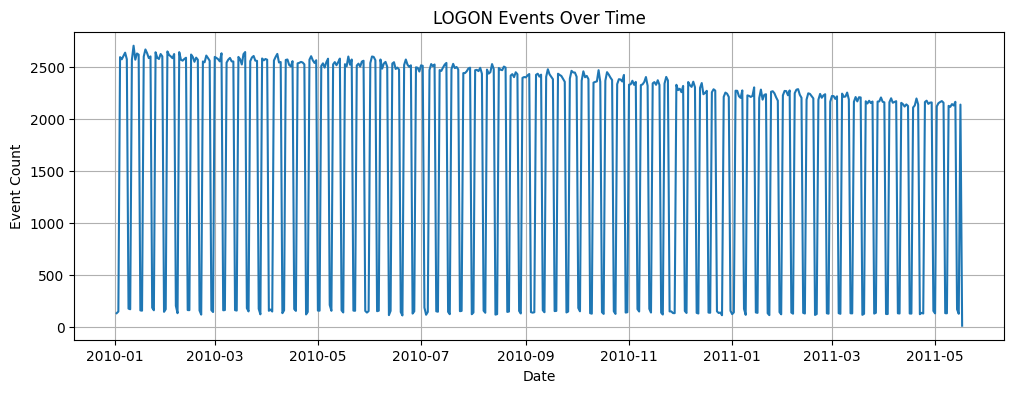

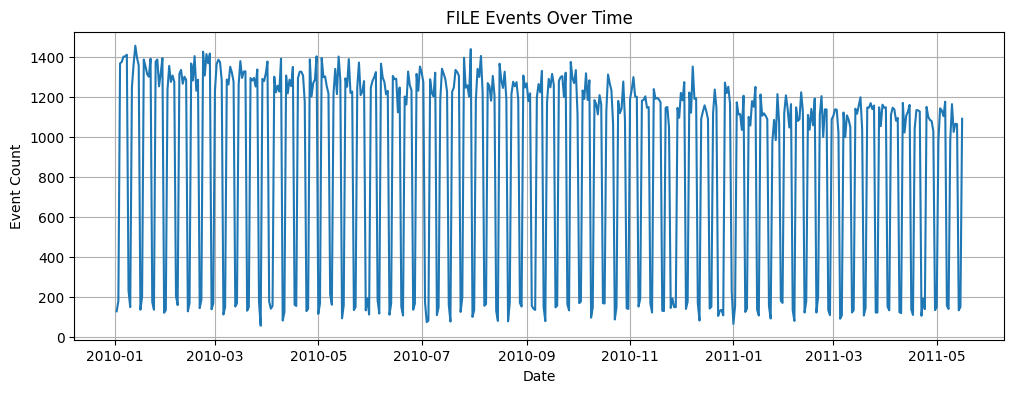

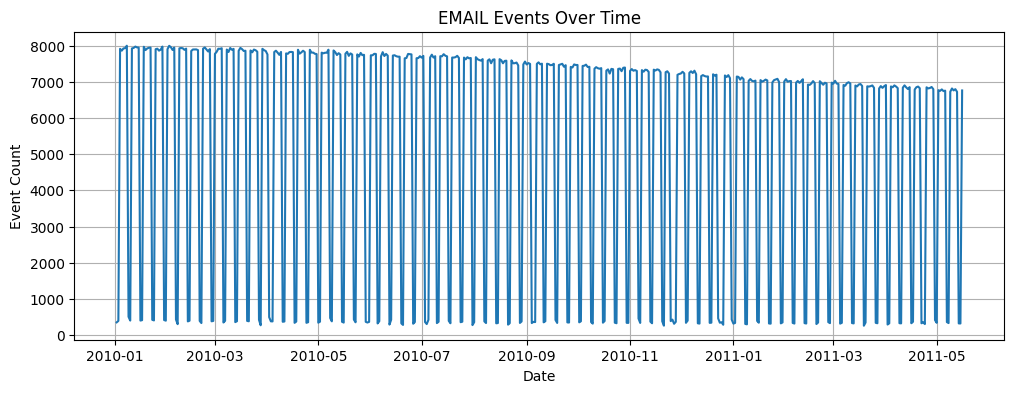

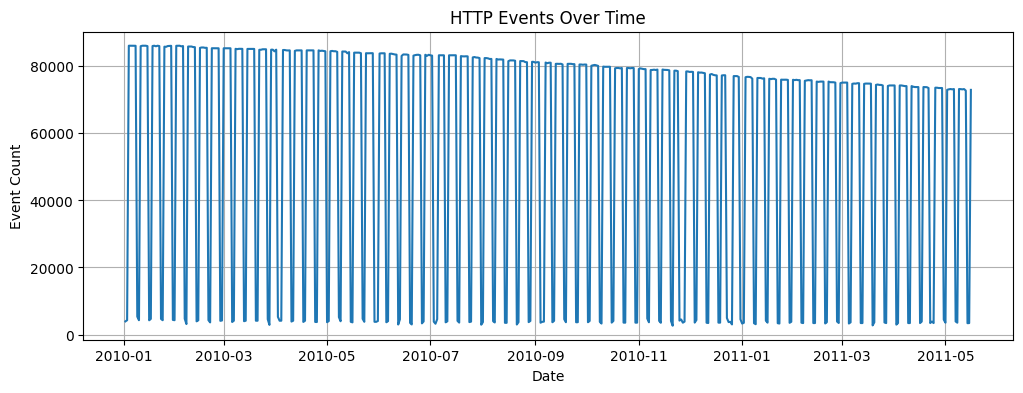

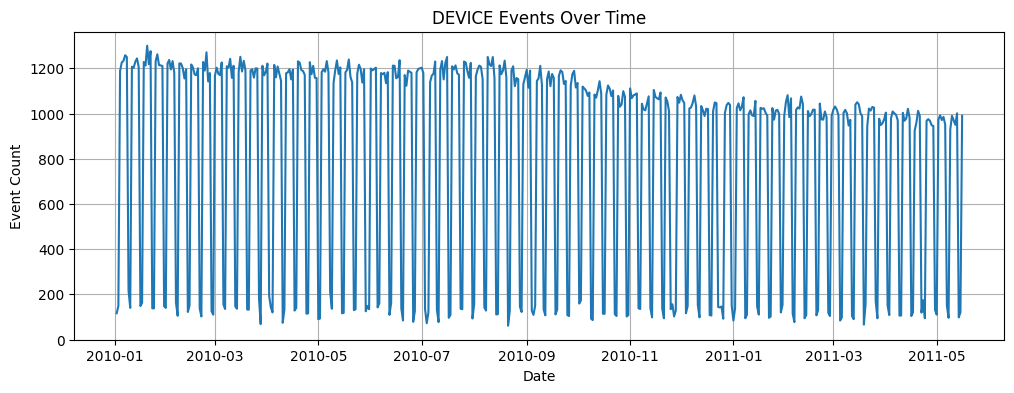

In [12]:
import matplotlib.pyplot as plt

def plot_events_over_time(df, name):
    daily = df.groupby(df["date"].dt.date).size()
    plt.figure(figsize=(12,4))
    plt.plot(daily.index, daily.values)
    plt.title(f"{name.upper()} Events Over Time")
    plt.xlabel("Date")
    plt.ylabel("Event Count")
    plt.grid(True)
    plt.show()


plot_events_over_time(logon, "logon")
plot_events_over_time(file, "file")
plot_events_over_time(email, "email")
plot_events_over_time(http, "http")
plot_events_over_time(device, "device")


# Top Active Users (Behavior Skew)

In [13]:
def plot_top_users(df, name, top_n=10):
    top_users = df["user"].value_counts().head(top_n)
    plt.figure(figsize=(8,4))
    top_users.plot(kind="bar")
    plt.title(f"Top {top_n} Active Users in {name.upper()}")
    plt.ylabel("Event Count")
    plt.xticks(rotation=45)
    plt.show()


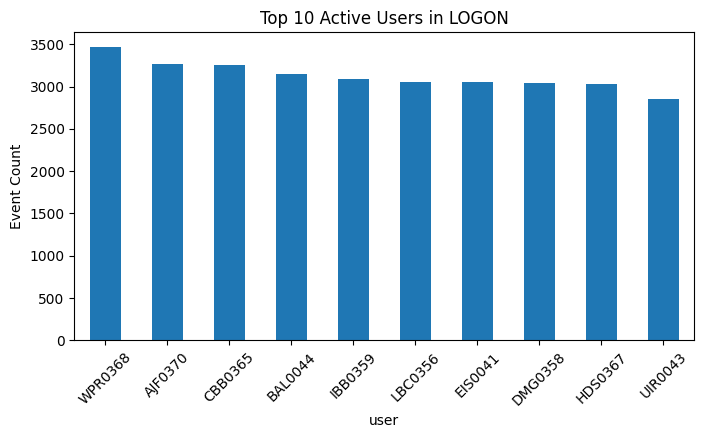

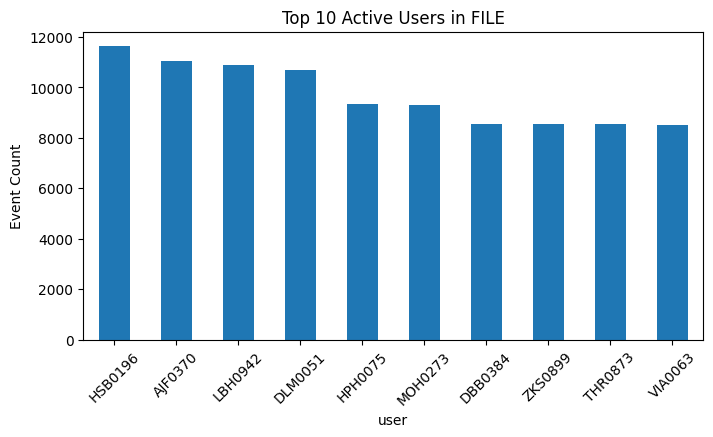

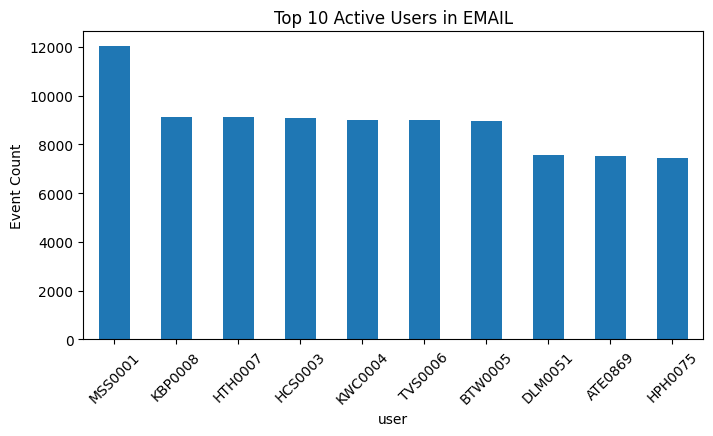

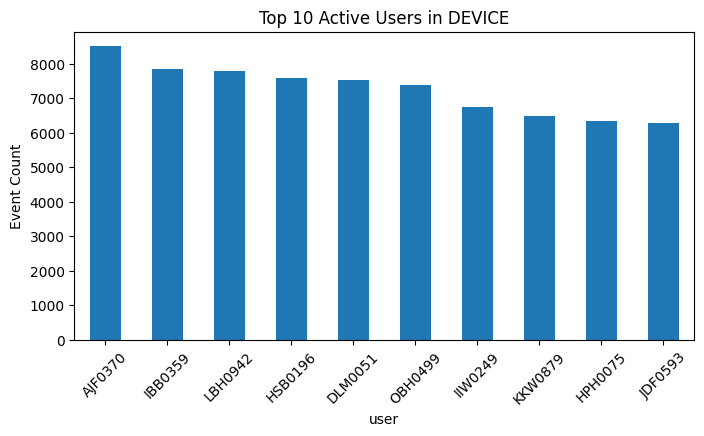

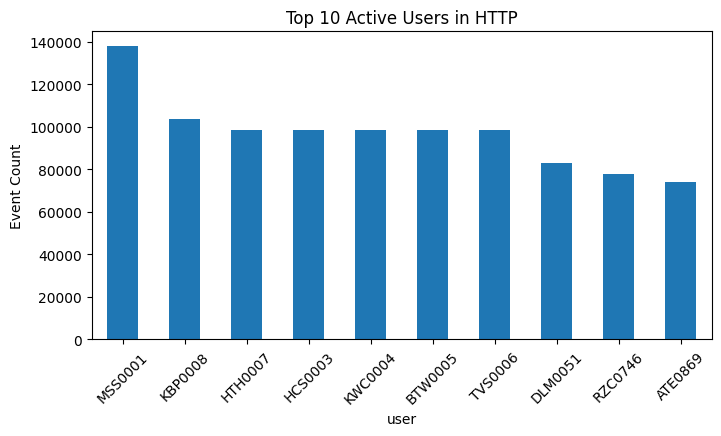

In [14]:
plot_top_users(logon, "logon")
plot_top_users(file, "file")
plot_top_users(email, "email")
plot_top_users(device, "device")
plot_top_users(http,"http")


# Hour-of-Day Activity (Off-Hours Behavior 🔥)

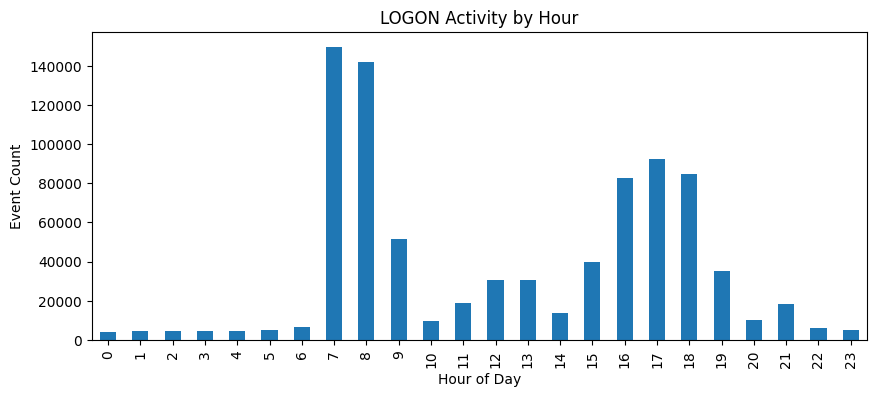

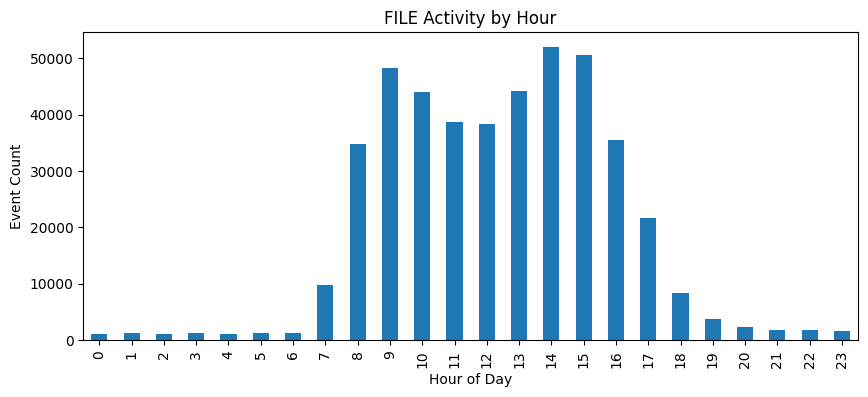

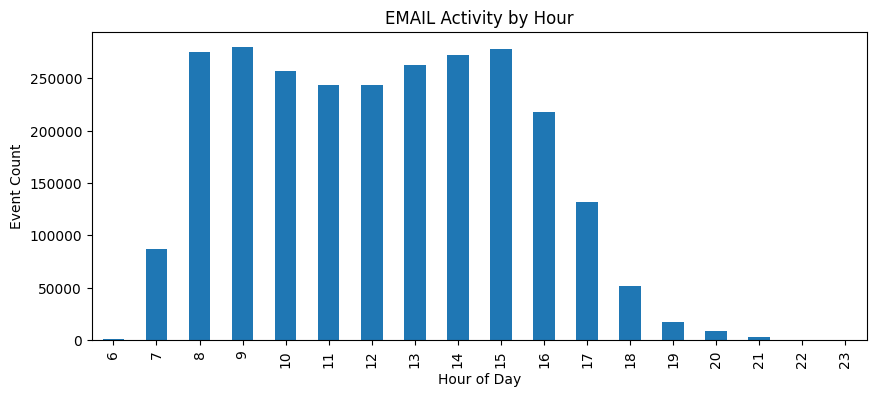

In [15]:
def plot_hour_distribution(df, name):
    hours = df["date"].dt.hour
    plt.figure(figsize=(10,4))
    hours.value_counts().sort_index().plot(kind="bar")
    plt.title(f"{name.upper()} Activity by Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("Event Count")
    plt.show()
plot_hour_distribution(logon, "logon")
plot_hour_distribution(file, "file")
plot_hour_distribution(email, "email")



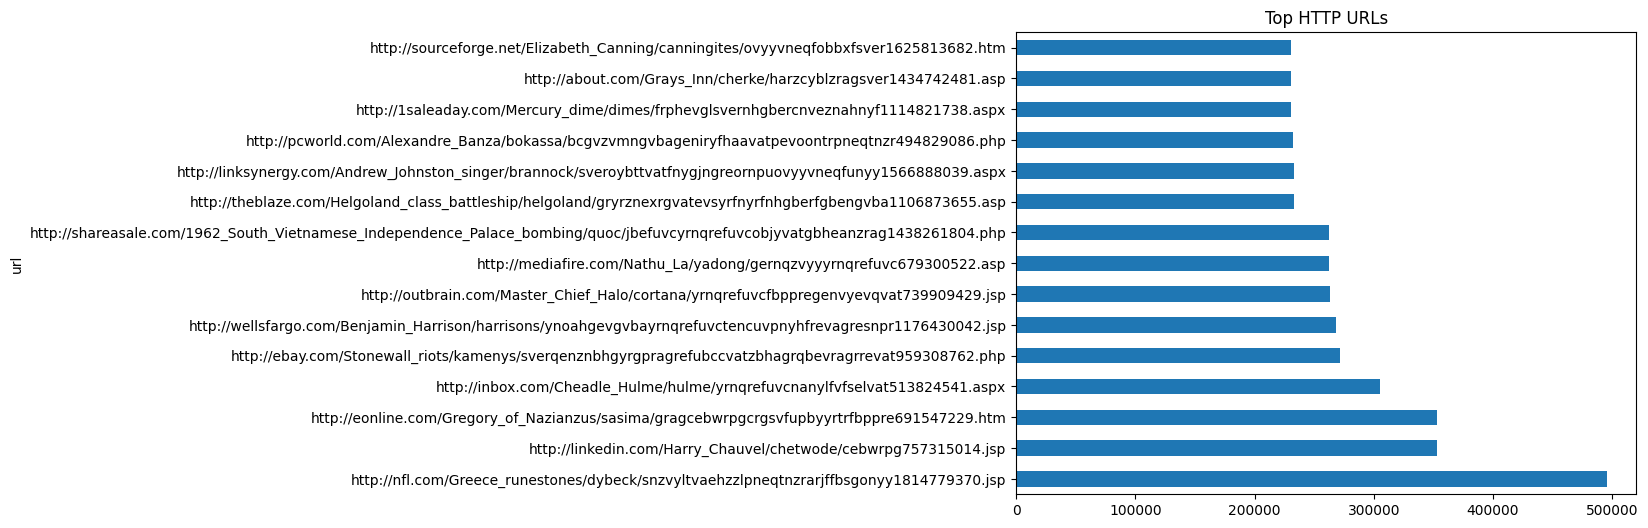

In [16]:
http["url"].value_counts().head(15).plot(kind="barh", figsize=(8,6), title="Top HTTP URLs")
plt.show()


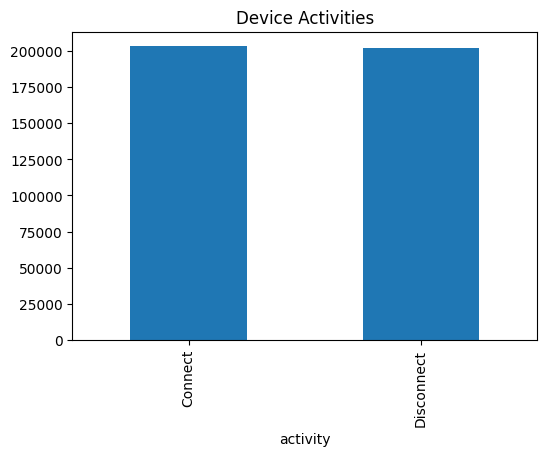

In [17]:
device["activity"].value_counts().plot(kind="bar", figsize=(6,4), title="Device Activities")
plt.show()


User-Level Threat Distribution
label
1    60
2    10
Name: count, dtype: int64


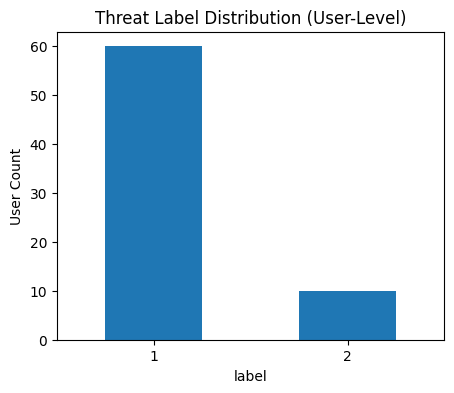

In [18]:
print("User-Level Threat Distribution")
print(threats["label"].value_counts())

plt.figure(figsize=(5,4))
threats["label"].value_counts().sort_index().plot(kind="bar")
plt.title("Threat Label Distribution (User-Level)")
plt.ylabel("User Count")
plt.xticks(rotation=0)
plt.show()


# Overlay: Threat Period vs Activity

In [19]:
def events_during_threat(df, threats):
    merged = df.merge(threats, on="user", how="inner")
    return merged[
        (merged["date"] >= merged["start"]) &
        (merged["date"] <= merged["end"])
    ]

# Logon (already done)
threat_logons = events_during_threat(logon, threats)

# Email
threat_emails = events_during_threat(email, threats)

# HTTP
threat_http = events_during_threat(http, threats)

# Device
threat_device = events_during_threat(device, threats)

print("Logon events during threat :", len(threat_logons))
print("Email events during threat :", len(threat_emails))
print("HTTP events during threat  :", len(threat_http))
print("Device events during threat:", len(threat_device))


Logon events during threat : 3448
Email events during threat : 9858
HTTP events during threat  : 107302
Device events during threat: 7087


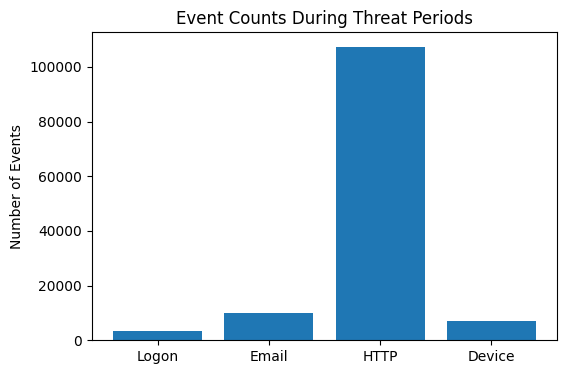

In [20]:
event_counts = {
    "Logon": len(threat_logons),
    "Email": len(threat_emails),
    "HTTP": len(threat_http),
    "Device": len(threat_device)
}

plt.figure(figsize=(6,4))
plt.bar(event_counts.keys(), event_counts.values())
plt.title("Event Counts During Threat Periods")
plt.ylabel("Number of Events")
plt.show()


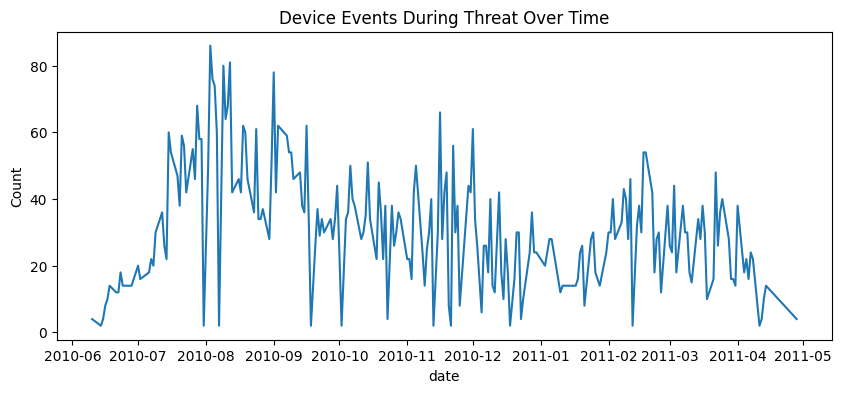

In [21]:
plt.figure(figsize=(10,4))
threat_device.groupby(threat_device["date"].dt.date).size().plot()
plt.title("Device Events During Threat Over Time")
plt.ylabel("Count")
plt.show()


# 2. feature extractioN


WINDOW CREATION

In [22]:
WINDOW_HOURS = 12

def create_windows(df):
    df = df.copy()
    df["window"] = df["date"].dt.floor(f"{WINDOW_HOURS}h")
    return df

logon  = create_windows(logon)
file   = create_windows(file)
email  = create_windows(email)
http   = create_windows(http)
device = create_windows(device)


In [23]:
logon.head()



,id,date,user,pc,activity,window
0,{X1D9-S0ES98JV-5357PWMI},2010-01-02 06:49:00,NGF0157,PC-6056,Logon,2010-01-02
1,{G2B3-L6EJ61GT-2222RKSO},2010-01-02 06:50:00,LRR0148,PC-4275,Logon,2010-01-02
2,{U6Q3-U0WE70UA-3770UREL},2010-01-02 06:53:04,LRR0148,PC-4124,Logon,2010-01-02
3,{I0N5-R7NA26TG-6263KNGM},2010-01-02 07:00:00,IRM0931,PC-7188,Logon,2010-01-02
4,{D1S0-N6FH62BT-5398KANK},2010-01-02 07:00:00,MOH0273,PC-6699,Logon,2010-01-02


In [24]:

email.head()

,id,date,user,pc,to,cc,bcc,from,size,attachments,content,window
0,{R3I7-S4TX96FG-8219JWFF},2010-01-02 07:11:45,LAP0338,PC-5758,Dean.Flynn.Hines@dtaa.com;Wade_Harrison@lockhe...,Nathaniel.Hunter.Heath@dtaa.com,,Lynn.Adena.Pratt@dtaa.com,25830,0,middle f2 systems 4 july techniques powerful d...,2010-01-02
1,{R0R9-E4GL59IK-2907OSWJ},2010-01-02 07:12:16,MOH0273,PC-6699,Odonnell-Gage@bellsouth.net,,,MOH68@optonline.net,29942,0,the breaking called allied reservations former...,2010-01-02
2,{G2B2-A8XY58CP-2847ZJZL},2010-01-02 07:13:00,LAP0338,PC-5758,Penelope_Colon@netzero.com,,,Lynn_A_Pratt@earthlink.net,28780,0,slowly this uncinus winter beneath addition ex...,2010-01-02
3,{A3A9-F4TH89AA-8318GFGK},2010-01-02 07:13:17,LAP0338,PC-5758,Judith_Hayden@comcast.net,,,Lynn_A_Pratt@earthlink.net,21907,0,400 other difficult land cirrocumulus powered ...,2010-01-02
4,{E8B7-C8FZ88UF-2946RUQQ},2010-01-02 07:13:28,MOH0273,PC-6699,Bond-Raymond@verizon.net;Alea_Ferrell@msn.com;...,,Odonnell-Gage@bellsouth.net,MOH68@optonline.net,17319,0,this kmh october holliswood number advised unu...,2010-01-02


# Event Density Over Time

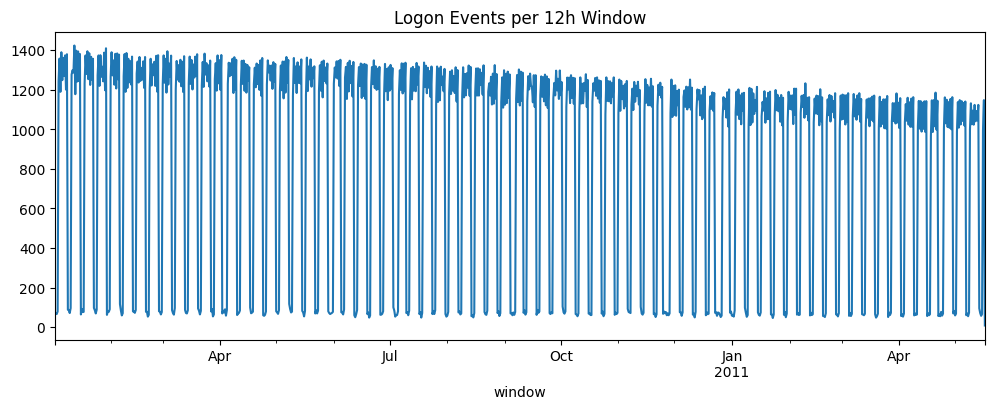

In [25]:
plt.figure(figsize=(12,4))
logon.groupby("window").size().plot()
plt.title("Logon Events per 12h Window")
plt.show()


# FEATURE EXTRACTION & ENGINEERING

In [26]:
base = pd.concat([
    logon[['user','window']],
    file[['user','window']],
    email[['user','window']],
    http[['user','window']],
    device[['user','window']]
]).drop_duplicates()

logon = logon.copy()
logon['is_off_hours'] = (
    (logon['date'].dt.hour < 6) |
    (logon['date'].dt.hour > 18)
).astype(int)

logon_counts  = logon.groupby(['user','window']).size().rename('logon_count')
file_counts   = file.groupby(['user','window']).size().rename('file_ops')
email_counts  = email.groupby(['user','window']).size().rename('emails_sent')
http_counts   = http.groupby(['user','window']).size().rename('http_visits')
device_counts = device.groupby(['user','window']).size().rename('usb_events')
off_hours_counts = logon.groupby(['user','window'])['is_off_hours'].sum().rename('off_hours')
pc_counts = logon.groupby(['user','window'])['pc'].nunique().rename('pc_count')

features_df = (
    base
    .merge(logon_counts, on=['user','window'], how='left')
    .merge(file_counts,  on=['user','window'], how='left')
    .merge(email_counts, on=['user','window'], how='left')
    .merge(http_counts,  on=['user','window'], how='left')
    .merge(device_counts,on=['user','window'], how='left')
    .merge(off_hours_counts, on=['user','window'], how='left')
    .merge(pc_counts, on=['user','window'], how='left')
    .fillna(0)
)




In [27]:
threats["numeric_label"] = 0
threats.loc[threats["what type of threat"].str.contains("exfiltration", case=False, na=False), "numeric_label"] = 1
threats.loc[threats["what type of threat"].str.contains("sabotage", case=False, na=False), "numeric_label"] = 2

WINDOW_HOURS = 12
features_df["window_end"] = features_df["window"] + pd.Timedelta(hours=WINDOW_HOURS)

merged = features_df.merge(
    threats[['user','start','end','numeric_label']],
    on='user', how='left'
)

overlap = (
    (merged["window"] <= merged["end"]) &
    (merged["window_end"] >= merged["start"])
)

merged.loc[~overlap, "numeric_label"] = 0

final_labels = (
    merged.groupby(['user','window'])['numeric_label']
    .max()
    .reset_index()
)

features_df = features_df.merge(final_labels, on=['user','window'], how='left')
features_df = features_df.rename(columns={'numeric_label':'label'}).fillna(0)
features_df["label"] = features_df["label"].astype(int)

features_df.drop(columns=["window_end"], inplace=True)

print(features_df["label"].value_counts())


label
0    657756
1      2634
2        39
Name: count, dtype: int64


# Log Transform + Scaling

Temporal Feature Engineering

In [28]:
from sklearn.preprocessing import StandardScaler
FEATURE_COLS = [
    "logon_count","file_ops","emails_sent",
    "http_visits","usb_events","off_hours","pc_count"
]

for c in FEATURE_COLS:
    features_df[c] = np.log1p(features_df[c])

features_df = features_df.sort_values(["user","window"])

for c in FEATURE_COLS:
    features_df[f"{c}_delta"] = features_df.groupby("user")[c].diff().fillna(0)
    features_df[f"{c}_roll"]  = (
        features_df.groupby("user")[c]
        .rolling(3)
        .mean()
        .reset_index(level=0, drop=True)
        .fillna(0)
    )

EXT_FEATURE_COLS = FEATURE_COLS + \
                   [f"{c}_delta" for c in FEATURE_COLS] + \
                   [f"{c}_roll" for c in FEATURE_COLS]

scaler = StandardScaler()
features_df[EXT_FEATURE_COLS] = scaler.fit_transform(
    features_df[EXT_FEATURE_COLS]
)


In [29]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 660429 entries, 836 to 660148
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   user               660429 non-null  object        
 1   window             660429 non-null  datetime64[ns]
 2   logon_count        660429 non-null  float64       
 3   file_ops           660429 non-null  float64       
 4   emails_sent        660429 non-null  float64       
 5   http_visits        660429 non-null  float64       
 6   usb_events         660429 non-null  float64       
 7   off_hours          660429 non-null  float64       
 8   pc_count           660429 non-null  float64       
 9   label              660429 non-null  int64         
 10  logon_count_delta  660429 non-null  float64       
 11  logon_count_roll   660429 non-null  float64       
 12  file_ops_delta     660429 non-null  float64       
 13  file_ops_roll      660429 non-null  float64    

In [30]:
features_df.describe()

,window,logon_count,file_ops,emails_sent,http_visits,usb_events,off_hours,pc_count,label,logon_count_delta,...,emails_sent_delta,emails_sent_roll,http_visits_delta,http_visits_roll,usb_events_delta,usb_events_roll,off_hours_delta,off_hours_roll,pc_count_delta,pc_count_roll
count,660429,6.604290e+05,6.604290e+05,6.604290e+05,6.604290e+05,6.604290e+05,6.604290e+05,6.604290e+05,660429.000000,6.604290e+05,...,6.604290e+05,6.604290e+05,6.604290e+05,6.604290e+05,6.604290e+05,6.604290e+05,6.604290e+05,6.604290e+05,6.604290e+05,6.604290e+05
mean,2010-08-31 05:25:27.256374528,-2.840325e-16,-6.438069e-17,-4.050475e-16,7.400337e-16,-3.735457e-17,1.273843e-17,1.535497e-16,0.004106,4.010950e-17,...,-1.949630e-17,8.539910e-16,-3.655304e-18,-1.191215e-16,2.157645e-17,-6.179858e-17,-4.875454e-17,-8.624259e-17,4.564928e-18,1.787683e-15
min,2010-01-02 00:00:00,-3.283806e+00,-3.055748e-01,-1.261175e+00,-3.333830e+00,-3.620052e-01,-3.139098e-01,-5.695372e+00,0.000000,-6.934882e+00,...,-2.705009e+00,-1.963151e+00,-8.806274e+00,-3.460242e+00,-7.400336e+00,-3.976867e-01,-7.152261e+00,-4.001607e-01,-1.123444e+01,-6.412315e+00
25%,2010-04-28 12:00:00,-4.131200e-01,-3.055748e-01,-1.261175e+00,-7.440827e-01,-3.620052e-01,-3.139098e-01,-2.175630e-01,0.000000,-3.529766e-04,...,-5.908232e-01,-8.143836e-01,-5.521116e-01,-7.290263e-01,-2.176274e-04,-3.976867e-01,-5.062653e-04,-4.001607e-01,6.463626e-05,-2.261752e-01
50%,2010-08-26 00:00:00,-4.131200e-01,-3.055748e-01,-9.502459e-02,4.017060e-01,-3.620052e-01,-3.139098e-01,-2.175630e-01,0.000000,-3.529766e-04,...,-2.231632e-04,7.473446e-02,-7.175784e-04,4.638284e-01,-2.176274e-04,-3.976867e-01,-5.062653e-04,-4.001607e-01,6.463626e-05,-2.261752e-01
75%,2011-01-04 00:00:00,-4.131200e-01,-3.055748e-01,9.461020e-01,7.625599e-01,-3.620052e-01,-3.139098e-01,-2.175630e-01,0.000000,-3.529766e-04,...,5.706637e-01,8.194642e-01,5.231207e-01,7.023876e-01,-2.176274e-04,-3.976867e-01,-5.062653e-04,-4.001607e-01,6.463626e-05,-2.261752e-01
max,2011-05-17 00:00:00,7.645915e+00,6.021572e+00,2.571727e+00,2.528360e+00,5.457771e+00,8.243311e+00,1.073805e+01,2.000000,6.934176e+00,...,2.704563e+00,3.270971e+00,8.804839e+00,2.173610e+00,7.596691e+00,5.136779e+00,7.151248e+00,8.655883e+00,1.015243e+01,8.952430e+00
std,NaN,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.064867,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00


In [31]:
features_df.head()


# print("next --")

# EXT_FEATURE_COLS

,user,window,logon_count,file_ops,emails_sent,http_visits,usb_events,off_hours,pc_count,label,...,emails_sent_delta,emails_sent_roll,http_visits_delta,http_visits_roll,usb_events_delta,usb_events_roll,off_hours_delta,off_hours_roll,pc_count_delta,pc_count_roll
836,AAE0190,2010-01-04 00:00:00,-0.41312,-0.305575,1.613355,0.731891,-0.362005,-0.31391,-0.217563,0,...,-0.000223,-1.963151,-0.000718,-3.460242,-0.000218,-0.397687,-0.000506,-0.400161,0.000065,-6.412315
1979,AAE0190,2010-01-04 12:00:00,-0.41312,-0.305575,-1.261175,0.990551,-0.362005,-0.31391,-0.217563,0,...,-2.028709,-1.963151,0.409645,-3.460242,-0.000218,-0.397687,-0.000506,-0.400161,0.000065,-6.412315
2851,AAE0190,2010-01-05 00:00:00,-0.41312,-0.305575,1.540121,0.650745,-0.362005,-0.31391,-0.217563,0,...,1.976583,0.990806,-0.539819,0.834057,-0.000218,-0.397687,-0.000506,-0.400161,0.000065,-0.226175
3999,AAE0190,2010-01-05 12:00:00,-0.41312,-0.305575,-1.261175,1.048634,-0.362005,-0.31391,-0.217563,0,...,-1.977029,-0.505229,0.630533,0.943974,-0.000218,-0.397687,-0.000506,-0.400161,0.000065,-0.226175
4810,AAE0190,2010-01-06 00:00:00,-0.41312,-0.305575,0.804362,0.835283,-0.362005,-0.31391,-0.217563,0,...,1.457376,0.569769,-0.339198,0.890092,-0.000218,-0.397687,-0.000506,-0.400161,0.000065,-0.226175


In [32]:
print("Total Feature Dimensions:", len(EXT_FEATURE_COLS))
EXT_FEATURE_COLS

Total Feature Dimensions: 21


['logon_count',
 'file_ops',
 'emails_sent',
 'http_visits',
 'usb_events',
 'off_hours',
 'pc_count',
 'logon_count_delta',
 'file_ops_delta',
 'emails_sent_delta',
 'http_visits_delta',
 'usb_events_delta',
 'off_hours_delta',
 'pc_count_delta',
 'logon_count_roll',
 'file_ops_roll',
 'emails_sent_roll',
 'http_visits_roll',
 'usb_events_roll',
 'off_hours_roll',
 'pc_count_roll']

# step label

In [33]:
# Step 1: Binary (Normal=0, Threat=1)
features_df["step1_label"] = (features_df["label"] > 0).astype(int)

# Step 2: Only meaningful for threat samples
# Exfil -> 0, Sabotage -> 1
features_df["step2_label"] = -1  # default for normal

features_df.loc[features_df["label"] == 1, "step2_label"] = 0
features_df.loc[features_df["label"] == 2, "step2_label"] = 1

print("Step1 distribution:")
print(features_df["step1_label"].value_counts())

print("\nStep2 distribution (only threats):")
print(features_df[features_df["step2_label"] != -1]["step2_label"].value_counts())


Step1 distribution:
step1_label
0    657756
1      2673
Name: count, dtype: int64

Step2 distribution (only threats):
step2_label
0    2634
1      39
Name: count, dtype: int64


# GRAPH CREATION & SPATIAL EMBEDDING

Window: 2010-01-04 00:00:00
User: AAE0190


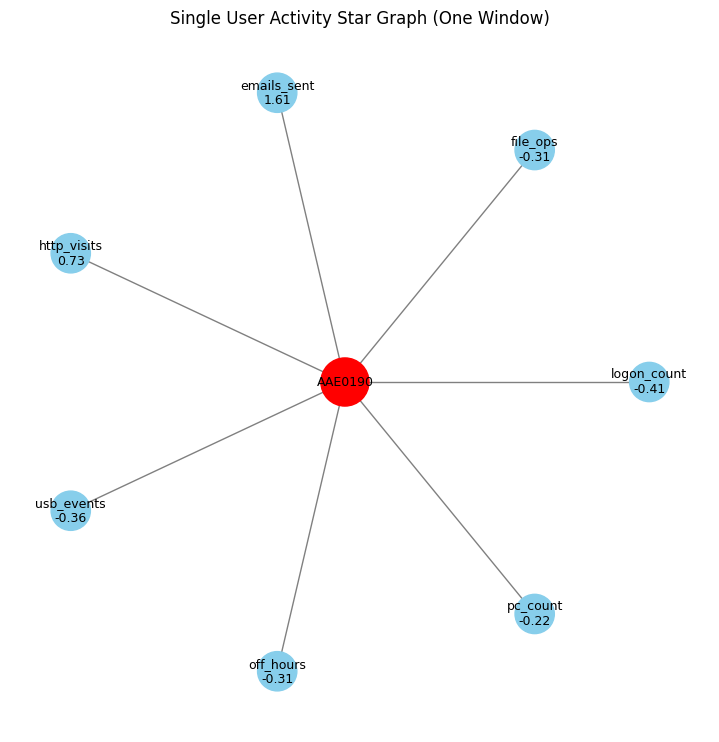

In [34]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Select one window
sample_window = features_df["window"].iloc[0]
window_df = features_df[features_df["window"] == sample_window]

# Select one user
center_user = window_df["user"].iloc[0]
user_row = window_df[window_df["user"] == center_user].iloc[0]

print("Window:", sample_window)
print("User:", center_user)

# Features to display
features_to_show = [
    "logon_count",
    "file_ops",
    "emails_sent",
    "http_visits",
    "usb_events",
    "off_hours",
    "pc_count"
]

# Create graph
G = nx.Graph()

# Add center node
G.add_node(center_user)

# Add feature nodes and edges
for feat in features_to_show:
    value = user_row[feat]
    G.add_node(feat)
    G.add_edge(center_user, feat, weight=value)

# Layout
pos = {}
pos[center_user] = (0, 0)

angle_step = 2 * np.pi / len(features_to_show)

for i, feat in enumerate(features_to_show):
    angle = i * angle_step
    pos[feat] = (1.5 * np.cos(angle), 1.5 * np.sin(angle))

# Draw
plt.figure(figsize=(7,7))

node_colors = ["red"] + ["skyblue"] * len(features_to_show)
node_sizes = [1200] + [800] * len(features_to_show)

nx.draw(
    G,
    pos,
    with_labels=False,
    node_color=node_colors,
    node_size=node_sizes,
    edge_color="gray"
)

# Node labels
labels = {center_user: center_user}
for feat in features_to_show:
    value = user_row[feat]
    labels[feat] = f"{feat}\n{value:.2f}"

nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

plt.title("Single User Activity Star Graph (One Window)")
plt.show()


**Window → Graph Visualization**

In [35]:
import torch
from torch_geometric.data import Data

x = torch.tensor(
    window_df[EXT_FEATURE_COLS].values,
    dtype=torch.float
)

num_nodes = x.shape[0]

edge_list = []
for i in range(num_nodes):
    for j in range(num_nodes):
        if i != j:
            edge_list.append([i, j])

edge_index = torch.tensor(edge_list).t().contiguous()

graph_data = Data(x=x, edge_index=edge_index)


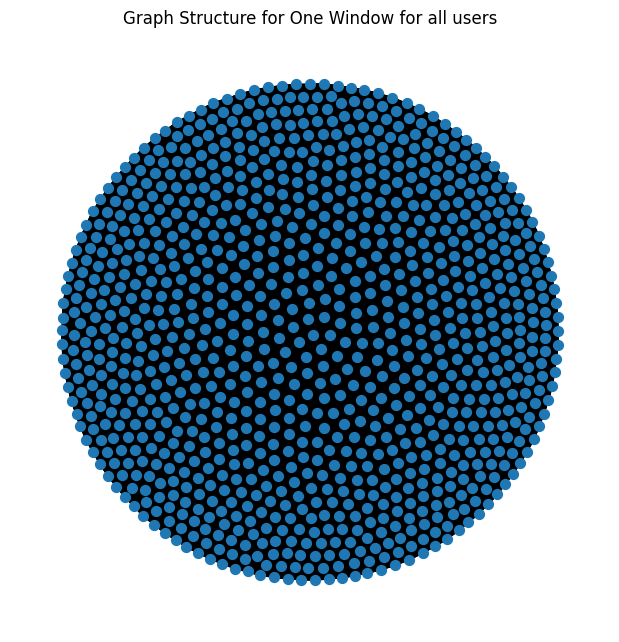

In [36]:
import networkx as nx

G = nx.complete_graph(num_nodes)

plt.figure(figsize=(6,6))
nx.draw(G, node_size=50, with_labels=False)
plt.title("Graph Structure for One Window for all users")
plt.show()


Simple explanation 👇

This picture shows **one 12-hour window** of your data.

* 🔵 Each blue dot = one user active in that window
* 🔗 Every user is connected to every other user
* That’s why it looks like a big solid circle

You used a **complete graph**, which means:

> Everyone is connected to everyone.

Because there are many users, the graph becomes very dense, so you don’t see individual edges — just a filled circle.

---

### What it means for your model

In that window:

* Each user’s features are compared with all other users
* The GNN learns how a user behaves relative to others
* It helps detect abnormal behavior

---

So in simple words:

> This circle = all users in one time window, fully connected so the model can compare them.

That’s it 🙂


**Graph → Spatial Embedding (GNN)**

# GNN Encoder

In [37]:
from torch_geometric.nn import SAGEConv

class GNNEncoder(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, 64)
        self.conv2 = SAGEConv(64, 32)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gnn_encoder = GNNEncoder(len(EXT_FEATURE_COLS)).to(device)


**Generate Spatial Embedding**

In [38]:
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
import torch.nn as nn
import torch

class GNNEncoder(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, 64)
        self.conv2 = SAGEConv(64, 32)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gnn_encoder = GNNEncoder(len(EXT_FEATURE_COLS)).to(device)

# Example forward pass
with torch.no_grad():
    spatial_embeddings = gnn_encoder(
        graph_data.x.to(device),
        graph_data.edge_index.to(device)
    )

print("Spatial embedding shape:", spatial_embeddings.shape)


Spatial embedding shape: torch.Size([1000, 32])


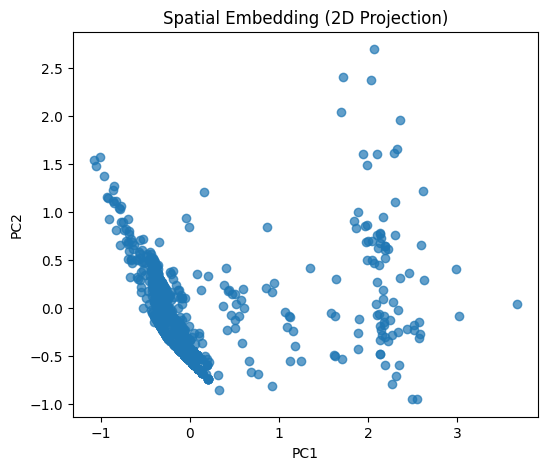

In [39]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)

emb_2d = pca.fit_transform(
    spatial_embeddings.detach().cpu().numpy()
)

plt.figure(figsize=(6,5))
plt.scatter(emb_2d[:,0], emb_2d[:,1], alpha=0.7)
plt.title("Spatial Embedding (2D Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [40]:
window_embeddings = {}
print("running")
gnn_encoder.eval()

for window, group in features_df.groupby("window"):

    x = torch.tensor(
        group[EXT_FEATURE_COLS].values,
        dtype=torch.float
    ).to(device)

    num_nodes = x.shape[0]

    if num_nodes < 2:
        continue

    # Star graph (node 0 connected to all others)
    edge_list = []
    for i in range(1, num_nodes):
        edge_list.append([0, i])
        edge_list.append([i, 0])

    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous().to(device)

    with torch.no_grad():
        emb = gnn_encoder(x, edge_index)

    # Store embeddings mapped by user
    window_embeddings[window] = {
        user: emb[i].cpu()
        for i, user in enumerate(group["user"].values)
    }

print("Window embeddings computed:", len(window_embeddings))


running
Window embeddings computed: 1001


Excellent question 👍
This shows you’re thinking correctly about modeling vs visualization.

---

## 🔷 Why Are We Using PCA Here?

You used:

```python
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(spatial_embeddings.numpy())
```

That is **only for visualization**.

Your GNN outputs:

```
spatial_embeddings shape = (num_users, 32)
```

That means each user has a **32-dimensional embedding**.

Humans cannot visualize 32 dimensions.

So PCA reduces:

```
32D → 2D
```

so we can plot it on a 2D scatter plot.

---

## 🔷 Why Not Use PCA Inside the Model?

Because PCA:

* Is linear
* Is unsupervised
* Is not trainable inside backprop
* Loses information

Your model (GNN + LSTM) learns:

> Optimal nonlinear representation for classification

If you applied PCA inside the model:

* You would reduce information before learning
* You might lose important signal
* It would not adapt during training

Deep models already learn dimensionality reduction internally.

---

## 🔷 Key Difference

### PCA here is for:

👀 Visualization only
📊 Understanding embedding structure
📈 Seeing clustering behavior

---

### GNN embedding is for:

🧠 Learning meaningful representation
🎯 Optimizing classification
🔁 Backpropagation

---

## 🔷 Think of It Like This

Your GNN produces:

```
32 numbers per user
```

We just compress those 32 numbers into 2 numbers so **we can see them on a graph**.

The model still uses all 32 dimensions.

---

## 🔷 Simple Analogy

Imagine:

* Model works in 32D space (very rich information)
* PCA is just a camera that takes a 2D photo of that space

The camera is not part of the learning.

---

## 🔷 When Would You Use PCA in Model?

Only if:

* You want dimensionality reduction before modeling
* Or you’re using classical ML (e.g., SVM, Logistic Regression)
* Or computational constraints exist

But in deep learning:

> Let the network learn its own projection.

---

## 🔷 Final Simple Answer

We use PCA here:

👉 Only to visualize 32D embeddings in 2D.

We do NOT use it in the model because:

👉 The model already learns better nonlinear embeddings.

---

If you want, I can also explain:

* Why t-SNE sometimes looks better than PCA
* Or how to visualize Normal vs Threat clusters
* Or how to interpret embedding separation

Tell me which one you want.


In [41]:
# plt.figure(figsize=(8,4))
# plt.plot(sequence_tensor[:,0].numpy())
# plt.title("Temporal Evolution of Spatial Feature (Dim 0)")
# plt.xlabel("Window Index")
# plt.ylabel("Embedding Value")
# plt.show()


# SEQUENCE CREATION

In [42]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim,
            64,
            batch_first=True,
            dropout=0.4
        )

    def forward(self, x):
        # x shape: (batch, seq_len, embed_dim)
        out, (h, _) = self.lstm(x)
        return h[-1]   # last layer hidden state


In [43]:
# with torch.no_grad():
#     temporal_representation = lstm_model(sequence_tensor)

# print("LSTM Output Shape:", temporal_representation.shape)


In [44]:
# plt.figure(figsize=(6,4))
# plt.bar(range(len(temporal_representation)), 
#         temporal_representation.numpy())
# plt.title("Final LSTM Behavioral Representation")
# plt.xlabel("Dimension")
# plt.ylabel("Activation")
# plt.show()


In [110]:
SEQUENCE_LEN = 14

def create_graph_sequences(df):

    sequences = []
    s1_labels = []
    s2_labels = []
    original_labels = []

    # Get embedding dimension safely
    sample_window = next(iter(window_embeddings))
    sample_user = next(iter(window_embeddings[sample_window]))
    embedding_dim = window_embeddings[sample_window][sample_user].shape[0]

    for user, group in df.groupby("user"):

        group = group.sort_values("window").reset_index(drop=True)

        for idx in range(len(group)):

            seq_embeddings = []

            # -----------------------------
            # Build sequence ending at idx
            # -----------------------------
            for step in range(SEQUENCE_LEN):

                past_idx = idx - (SEQUENCE_LEN - 1 - step)

                if past_idx < 0:
                    # Zero padding for early windows
                    seq_embeddings.append(torch.zeros(embedding_dim))
                else:
                    window = group.iloc[past_idx]["window"]

                    if (
                        window in window_embeddings and
                        user in window_embeddings[window]
                    ):
                        emb = window_embeddings[window][user]
                        seq_embeddings.append(emb)
                    else:
                        seq_embeddings.append(torch.zeros(embedding_dim))

            seq_tensor = torch.stack(seq_embeddings)

            # -----------------------------
            # EPISODE-BASED LABELING
            # -----------------------------
            window_labels = group.iloc[
                max(0, idx - SEQUENCE_LEN + 1): idx + 1
            ]["label"].values

            if 2 in window_labels:
                orig = 2
            elif 1 in window_labels:
                orig = 1
            else:
                orig = 0

            # Step 1: Threat vs Normal
            s1 = 1 if orig > 0 else 0

            # Step 2: Exfil vs Sabotage
            if orig == 1:
                s2 = 0
            elif orig == 2:
                s2 = 1
            else:
                s2 = -1  # Not threat

            sequences.append(seq_tensor)
            s1_labels.append(s1)
            s2_labels.append(s2)
            original_labels.append(orig)

    return (
        torch.stack(sequences),
        torch.tensor(s1_labels),
        torch.tensor(s2_labels),
        torch.tensor(original_labels)
    )


# datset loader

In [111]:
users = features_df["user"].unique()

train_users, temp_users = train_test_split(
    users, test_size=0.30, random_state=42
)

val_users, test_users = train_test_split(
    temp_users, test_size=0.50, random_state=42
)

train_df = features_df[features_df["user"].isin(train_users)]
val_df   = features_df[features_df["user"].isin(val_users)]
test_df  = features_df[features_df["user"].isin(test_users)]

print("Train windows:", len(train_df))
print("Val windows  :", len(val_df))
print("Test windows :", len(test_df))

print("\nUSER SPLIT SIZES---")
print("-------------------")
print(f"Train Users: {len(train_users)} ({len(train_users)/len(users)*100:.2f}%)")
print(f"Val Users  : {len(val_users)} ({len(val_users)/len(users)*100:.2f}%)")
print(f"Test Users : {len(test_users)} ({len(test_users)/len(users)*100:.2f}%)")
print(f"Total Users: {len(users)}")


Train windows: 462370
Val windows  : 100310
Test windows : 97749

USER SPLIT SIZES---
-------------------
Train Users: 700 (70.00%)
Val Users  : 150 (15.00%)
Test Users : 150 (15.00%)
Total Users: 1000


In [112]:
print("\nLABEL DISTRIBUTION (Window Level)")
print("-----------------------------------")

for name, df in zip(
    ["Train","Validation","Test"],
    [train_df, val_df, test_df]
):
    print(f"\n{name} Split:")
    print(df["label"].value_counts())



LABEL DISTRIBUTION (Window Level)
-----------------------------------

Train Split:
label
0    460399
1      1948
2        23
Name: count, dtype: int64

Validation Split:
label
0    100139
1       163
2         8
Name: count, dtype: int64

Test Split:
label
0    97218
1      523
2        8
Name: count, dtype: int64


In [114]:
print("start")
X_train, y1_train, y2_train, y_orig_train = create_graph_sequences(train_df)
print("train over")

print("Train sequences:", len(X_train))


start
train over
Train sequences: 462370


In [115]:
y1_train

tensor([0, 0, 0,  ..., 0, 0, 0])

In [116]:
X_val, y1_val, y2_val, y_orig_val = create_graph_sequences(val_df)
print("val over")


val over


In [117]:
X_test, y1_test, y2_test, y_orig_test = create_graph_sequences(test_df)


In [118]:
# ==========================================
# OVERSAMPLE SABOTAGE SEQUENCES
# ==========================================

sabotage_idx = (y_orig_train == 2)

X_sab = X_train[sabotage_idx]
y1_sab = y1_train[sabotage_idx]
y2_sab = y2_train[sabotage_idx]
y_orig_sab = y_orig_train[sabotage_idx]

print("Original sabotage sequences:", len(X_sab))

REPEAT_FACTOR = 3 # Try 5–8

X_train = torch.cat([X_train] + [X_sab] * REPEAT_FACTOR)
y1_train = torch.cat([y1_train] + [y1_sab] * REPEAT_FACTOR)
y2_train = torch.cat([y2_train] + [y2_sab] * REPEAT_FACTOR)
y_orig_train = torch.cat([y_orig_train] + [y_orig_sab] * REPEAT_FACTOR)

print("After oversampling total sequences:", len(X_train))


Original sabotage sequences: 28
After oversampling total sequences: 462454


In [119]:
print("check")

check


In [120]:
class SequenceDataset(Dataset):
    def __init__(self, X, y1, y2, y_orig):
        self.X = X
        self.y1 = y1
        self.y2 = y2
        self.y_orig = y_orig

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (
            self.X[idx].to(device),
            self.y1[idx].to(device),
            self.y2[idx].to(device),
            self.y_orig[idx].to(device)
        )


In [121]:
train_loader = DataLoader(
    SequenceDataset(X_train, y1_train, y2_train, y_orig_train),
    batch_size=64,
    shuffle=True
)

val_loader = DataLoader(
    SequenceDataset(X_val, y1_val, y2_val, y_orig_val),
    batch_size=64
)

test_loader = DataLoader(
    SequenceDataset(X_test, y1_test, y2_test, y_orig_test),
    batch_size=64
)


# Focal loos

In [122]:
import torch.nn.functional as F
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, pos_weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight

    def forward(self, inputs, targets):
        bce = F.binary_cross_entropy_with_logits(
            inputs,
            targets,
            reduction='none',
            pos_weight=self.pos_weight
        )
        pt = torch.exp(-bce)
        loss = self.alpha * (1 - pt) ** self.gamma * bce
        return loss.mean()


# 2-STEP MODEL (GNN → LSTM)

In [123]:
class TwoStepLSTM(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.lstm = nn.LSTM(
            input_dim,
            64,
            batch_first=True
        )

        self.dropout = nn.Dropout(0.2)

        self.step1 = nn.Linear(64, 1)   # Binary threat
        self.step2 = nn.Linear(64, 2)   # Exfil vs Sabotage

    def forward(self, x):
        out, _ = self.lstm(x)
        h = out[:, -1, :]
        h = self.dropout(h)

        s1 = self.step1(h)
        s2 = self.step2(h)

        return s1, s2


In [124]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TwoStepLSTM(X_train.shape[2]).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-5
)

# ==========================================
# STEP 1 LOSS (Focal)
# ==========================================

num_normal = (y1_train == 0).sum().item()
num_threat = (y1_train == 1).sum().item()

pos_weight = torch.tensor(num_normal / num_threat).to(device)

criterion_step1 = FocalLoss(
    alpha=1,
    gamma=2,
    pos_weight=pos_weight
)

# ==========================================
# STEP 2 LOSS (Stronger)
# ==========================================

threat_mask = (y1_train == 1)
y2_threat = y2_train[threat_mask]

num_exfil = (y2_threat == 0).sum().item()
num_sabotage = (y2_threat == 1).sum().item()

print("Step2 counts:")
print("Exfil:", num_exfil)
print("Sabotage:", num_sabotage)

# 🔥 Strong imbalance weight (NO normalization)
weight_step2 = torch.tensor([
    1.0,
    num_exfil / max(1, num_sabotage)
], dtype=torch.float).to(device)

criterion_step2 = nn.CrossEntropyLoss(
    weight=weight_step2,
    label_smoothing=0.05
)


Step2 counts:
Exfil: 2348
Sabotage: 112


In [125]:
print("Validation window sabotage count:",
      (val_df["label"] == 2).sum())

print("Validation sequence sabotage count:",
      (y_orig_val == 2).sum())


Validation window sabotage count: 8
Validation sequence sabotage count: tensor(8)


# Compute Class Weights for Step 2

In [126]:
# Only threat samples for Step2
threat_mask = (y1_train == 1)

y2_threat = y2_train[threat_mask]

num_exfil = (y2_threat == 0).sum().item()
num_sabotage = (y2_threat == 1).sum().item()

print("Step2 class counts:")
print("Exfil:", num_exfil)
print("Sabotage:", num_sabotage)

# Inverse frequency weights (correct way)
weight_step2 = torch.tensor([
    1.0 / num_exfil,
    1.0 / num_sabotage
], dtype=torch.float)

weight_step2 = weight_step2 / weight_step2.sum()
weight_step2 = weight_step2.to(device)

print("Step2 class weights:", weight_step2)


Step2 class counts:
Exfil: 2348
Sabotage: 112
Step2 class weights: tensor([0.0455, 0.9545], device='cuda:0')


# Define Loss Functions

In [127]:
num_normal = (y1_train == 0).sum().item()
num_threat = (y1_train == 1).sum().item()

pos_weight = torch.tensor(num_normal / num_threat).to(device)

criterion_step1 = FocalLoss(
    alpha=1,
    gamma=2,
    pos_weight=pos_weight
)

threat_mask = (y1_train == 1)

y2_threat = y2_train[threat_mask]

num_exfil = (y2_threat == 0).sum().item()
num_sabotage = (y2_threat == 1).sum().item()

weight_step2 = torch.tensor([
    1.0 / num_exfil,
    1.0 / num_sabotage
], dtype=torch.float)

weight_step2 = weight_step2 / weight_step2.sum()
weight_step2 = weight_step2.to(device)

criterion_step2 = nn.CrossEntropyLoss(weight=weight_step2)



# TRAINING

In [128]:
# from sklearn.metrics import (
#     accuracy_score,
#     precision_score,
#     recall_score,
#     f1_score,
#     confusion_matrix
# )

# from sklearn.metrics import (
#     accuracy_score,
#     precision_score,
#     recall_score,
#     f1_score,
#     confusion_matrix
# )

# EPOCHS = 30
# PATIENCE = 8

# best_val_sabotage_recall = 0
# best_val_exfil_recall = 0
# best_val_loss = float("inf")
# patience_counter = 0

# for epoch in range(EPOCHS):

#     print(f"\n================ Epoch {epoch+1}/{EPOCHS} ================")

#     # =========================
#     # TRAIN
#     # =========================
#     model.train()
#     total_loss = 0

#     all_preds_train = []
#     all_true_train = []

#     total_batches = len(train_loader)

#     for batch_idx, (X, y1, y2, y_orig) in enumerate(train_loader):

#         print(
#             f"\rEpoch {epoch+1}/{EPOCHS} | Batch {batch_idx+1}/{total_batches}",
#             end="", flush=True
#         )

#         optimizer.zero_grad()

#         s1, s2 = model(X)

#         loss1 = criterion_step1(s1.squeeze(), y1.float())

#         mask = (y1 == 1)
#         if mask.sum() > 0:
#             loss2 = criterion_step2(s2[mask], y2[mask])
#         else:
#             loss2 = torch.tensor(0.0, device=device)

#         loss = loss1 + loss2
#         loss.backward()

#         torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
#         optimizer.step()

#         total_loss += loss.item()

#         prob = torch.sigmoid(s1).squeeze()
#         pred1 = (prob > 0.5).long()

#         final_pred = torch.zeros_like(pred1)
#         threat_idx = (pred1 == 1)

#         if threat_idx.sum() > 0:
#             pred2 = torch.argmax(s2[threat_idx], dim=1)
#             final_pred[threat_idx] = pred2 + 1

#         all_preds_train.extend(final_pred.cpu().numpy())
#         all_true_train.extend(y_orig.cpu().numpy())

#     print()

#     train_loss = total_loss / total_batches

#     train_acc = accuracy_score(all_true_train, all_preds_train)
#     train_prec = precision_score(all_true_train, all_preds_train, average='macro', zero_division=0)
#     train_rec = recall_score(all_true_train, all_preds_train, average='macro', zero_division=0)
#     train_f1 = f1_score(all_true_train, all_preds_train, average='macro')

#     train_cm = confusion_matrix(all_true_train, all_preds_train)

#     # =========================
#     # VALIDATION
#     # =========================
#     model.eval()
#     val_loss_total = 0

#     all_preds_val = []
#     all_true_val = []

#     total_val_batches = len(val_loader)

#     with torch.no_grad():
#         for batch_idx, (X, y1, y2, y_orig) in enumerate(val_loader):

#             print(
#                 f"\rValidating... Batch {batch_idx+1}/{total_val_batches}",
#                 end="", flush=True
#             )

#             s1, s2 = model(X)

#             loss1 = criterion_step1(s1.squeeze(), y1.float())

#             mask = (y1 == 1)
#             if mask.sum() > 0:
#                 loss2 = criterion_step2(s2[mask], y2[mask])
#             else:
#                 loss2 = torch.tensor(0.0, device=device)

#             val_loss_total += (loss1 + loss2).item()

#             prob = torch.sigmoid(s1).squeeze()
#             pred1 = (prob > 0.5).long()

#             final_pred = torch.zeros_like(pred1)
#             threat_idx = (pred1 == 1)

#             if threat_idx.sum() > 0:
#                 pred2 = torch.argmax(s2[threat_idx], dim=1)
#                 final_pred[threat_idx] = pred2 + 1

#             all_preds_val.extend(final_pred.cpu().numpy())
#             all_true_val.extend(y_orig.cpu().numpy())

#     print()

#     val_loss = val_loss_total / total_val_batches

#     val_acc = accuracy_score(all_true_val, all_preds_val)
#     val_prec = precision_score(all_true_val, all_preds_val, average='macro', zero_division=0)
#     val_rec = recall_score(all_true_val, all_preds_val, average='macro', zero_division=0)
#     val_f1 = f1_score(all_true_val, all_preds_val, average='macro')

#     val_rec_per_class = recall_score(
#         all_true_val, all_preds_val, average=None, zero_division=0
#     )

#     val_cm = confusion_matrix(all_true_val, all_preds_val)

#     # Class order: 0=Normal, 1=Exfil, 2=Sabotage
#     val_rec_exfil = val_rec_per_class[1]
#     val_rec_sabotage = val_rec_per_class[2]

#     # =========================
#     # PRINT METRICS
#     # =========================
#     print(f"\nTrain Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
#     print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
#     print(f"Train Macro-F1: {train_f1:.4f} | Val Macro-F1: {val_f1:.4f}")

#     print("\nTrain Confusion Matrix:")
#     print(train_cm)

#     print("\nValidation Confusion Matrix:")
#     print(val_cm)

#     print(f"\nPrimary  → Sabotage Recall: {val_rec_sabotage:.4f}")
#     print(f"Secondary → Exfil Recall: {val_rec_exfil:.4f}")
#     print(f"Tie-break → Validation Loss: {val_loss:.4f}")

#     # =========================
#     # MODEL SELECTION LOGIC
#     # =========================
#     save_model = False

#     if val_rec_sabotage > best_val_sabotage_recall:
#         save_model = True

#     elif val_rec_sabotage == best_val_sabotage_recall:
#         if val_rec_exfil > best_val_exfil_recall:
#             save_model = True

#         elif val_rec_exfil == best_val_exfil_recall:
#             if val_loss < best_val_loss:
#                 save_model = True

#     if save_model:
#         best_val_sabotage_recall = val_rec_sabotage
#         best_val_exfil_recall = val_rec_exfil
#         best_val_loss = val_loss
#         patience_counter = 0

#         torch.save(model.state_dict(), "best_model.pt")
#         print("✅ New best model saved (Sabotage → Exfil → Loss rule)")

#     else:
#         patience_counter += 1

#     if patience_counter >= PATIENCE:
#         print("⛔ Early stopping triggered.")
#         break


In [129]:
# from sklearn.metrics import (
#     accuracy_score,
#     precision_score,
#     recall_score,
#     f1_score,
#     confusion_matrix
# )

# EPOCHS = 30
# PATIENCE = 8

# best_val_sabotage_recall = 0
# best_val_exfil_recall = 0
# best_val_loss = float("inf")
# patience_counter = 0

# for epoch in range(EPOCHS):

#     print(f"\n================ Epoch {epoch+1}/{EPOCHS} ================")

#     # =========================
#     # TRAIN
#     # =========================
#     model.train()
#     total_loss = 0

#     all_preds_train = []
#     all_true_train = []

#     total_batches = len(train_loader)

#     for batch_idx, (X, y1, y2, y_orig) in enumerate(train_loader):

#         # 🔥 Print every 200 batches
#         if (batch_idx + 1) % 200 == 0:
#             print(
#                 f"\rEpoch {epoch+1}/{EPOCHS} | Batch {batch_idx+1}/{total_batches}",
#                 end="", flush=True
#             )

#         optimizer.zero_grad()

#         s1, s2 = model(X)

#         loss1 = criterion_step1(s1.squeeze(), y1.float())

#         mask = (y1 == 1)
#         if mask.sum() > 0:
#             loss2 = criterion_step2(s2[mask], y2[mask])
#         else:
#             loss2 = torch.tensor(0.0, device=device)

#         loss = loss1 + loss2
#         loss.backward()

#         torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
#         optimizer.step()

#         total_loss += loss.item()

#         # Predictions
#         prob = torch.sigmoid(s1).squeeze()
#         pred1 = (prob > 0.5).long()

#         final_pred = torch.zeros_like(pred1)
#         threat_idx = (pred1 == 1)

#         if threat_idx.sum() > 0:
#             pred2 = torch.argmax(s2[threat_idx], dim=1)
#             final_pred[threat_idx] = pred2 + 1

#         all_preds_train.extend(final_pred.cpu().numpy())
#         all_true_train.extend(y_orig.cpu().numpy())

#     print()

#     train_loss = total_loss / total_batches

#     # =========================
#     # VALIDATION
#     # =========================
#     model.eval()
#     val_loss_total = 0

#     all_preds_val = []
#     all_true_val = []

#     total_val_batches = len(val_loader)

#     with torch.no_grad():
#         for batch_idx, (X, y1, y2, y_orig) in enumerate(val_loader):

#             if (batch_idx + 1) % 200 == 0:
#                 print(
#                     f"\rValidating... Batch {batch_idx+1}/{total_val_batches}",
#                     end="", flush=True
#                 )

#             s1, s2 = model(X)

#             loss1 = criterion_step1(s1.squeeze(), y1.float())

#             mask = (y1 == 1)
#             if mask.sum() > 0:
#                 loss2 = criterion_step2(s2[mask], y2[mask])
#             else:
#                 loss2 = torch.tensor(0.0, device=device)

#             val_loss_total += (loss1 + loss2).item()

#             prob = torch.sigmoid(s1).squeeze()
#             pred1 = (prob > 0.5).long()

#             final_pred = torch.zeros_like(pred1)
#             threat_idx = (pred1 == 1)

#             if threat_idx.sum() > 0:
#                 pred2 = torch.argmax(s2[threat_idx], dim=1)
#                 final_pred[threat_idx] = pred2 + 1

#             all_preds_val.extend(final_pred.cpu().numpy())
#             all_true_val.extend(y_orig.cpu().numpy())

#     print()

#     val_loss = val_loss_total / total_val_batches

#     # =========================
#     # FULL METRICS (TRAIN)
#     # =========================
#     train_acc = accuracy_score(all_true_train, all_preds_train)
#     train_prec_macro = precision_score(all_true_train, all_preds_train, average='macro', zero_division=0)
#     train_rec_macro = recall_score(all_true_train, all_preds_train, average='macro', zero_division=0)
#     train_f1_macro = f1_score(all_true_train, all_preds_train, average='macro')
#     train_f1_micro = f1_score(all_true_train, all_preds_train, average='micro')
#     train_f1_weighted = f1_score(all_true_train, all_preds_train, average='weighted')

#     train_prec_per_class = precision_score(all_true_train, all_preds_train, average=None, zero_division=0)
#     train_rec_per_class = recall_score(all_true_train, all_preds_train, average=None, zero_division=0)
#     train_f1_per_class = f1_score(all_true_train, all_preds_train, average=None, zero_division=0)

#     train_cm = confusion_matrix(all_true_train, all_preds_train)

#     # =========================
#     # FULL METRICS (VALIDATION)
#     # =========================
#     val_acc = accuracy_score(all_true_val, all_preds_val)
#     val_prec_macro = precision_score(all_true_val, all_preds_val, average='macro', zero_division=0)
#     val_rec_macro = recall_score(all_true_val, all_preds_val, average='macro', zero_division=0)
#     val_f1_macro = f1_score(all_true_val, all_preds_val, average='macro')
#     val_f1_micro = f1_score(all_true_val, all_preds_val, average='micro')
#     val_f1_weighted = f1_score(all_true_val, all_preds_val, average='weighted')

#     val_prec_per_class = precision_score(all_true_val, all_preds_val, average=None, zero_division=0)
#     val_rec_per_class = recall_score(all_true_val, all_preds_val, average=None, zero_division=0)
#     val_f1_per_class = f1_score(all_true_val, all_preds_val, average=None, zero_division=0)

#     val_cm = confusion_matrix(all_true_val, all_preds_val)

#     val_rec_exfil = val_rec_per_class[1]
#     val_rec_sabotage = val_rec_per_class[2]

#     # =========================
#     # PRINT METRICS
#     # =========================
#     print("\n================ PERFORMANCE SUMMARY ================")
#     print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

#     print("\n---- TRAIN ----")
#     print(f"Accuracy       : {train_acc:.4f}")
#     print(f"Macro Precision: {train_prec_macro:.4f}")
#     print(f"Macro Recall   : {train_rec_macro:.4f}")
#     print(f"Macro F1       : {train_f1_macro:.4f}")
#     print(f"Micro F1       : {train_f1_micro:.4f}")
#     print(f"Weighted F1    : {train_f1_weighted:.4f}")
#     print("Per-class Recall:", train_rec_per_class)

#     print("\nTrain Confusion Matrix:")
#     print(train_cm)

#     print("\n---- VALIDATION ----")
#     print(f"Accuracy       : {val_acc:.4f}")
#     print(f"Macro Precision: {val_prec_macro:.4f}")
#     print(f"Macro Recall   : {val_rec_macro:.4f}")
#     print(f"Macro F1       : {val_f1_macro:.4f}")
#     print(f"Micro F1       : {val_f1_micro:.4f}")
#     print(f"Weighted F1    : {val_f1_weighted:.4f}")
#     print("Per-class Recall:", val_rec_per_class)

#     print("\nValidation Confusion Matrix:")
#     print(val_cm)

#     print("\nSelection Metrics:")
#     print(f"Primary  → Sabotage Recall: {val_rec_sabotage:.4f}")
#     print(f"Secondary → Exfil Recall  : {val_rec_exfil:.4f}")
#     print(f"Tie-break → Validation Loss: {val_loss:.4f}")

#     # =========================
#     # MODEL SELECTION RULE
#     # =========================
#     save_model = False

#     if val_rec_sabotage > best_val_sabotage_recall:
#         save_model = True

#     elif val_rec_sabotage == best_val_sabotage_recall:
#         if val_rec_exfil > best_val_exfil_recall:
#             save_model = True
#         elif val_rec_exfil == best_val_exfil_recall:
#             if val_loss < best_val_loss:
#                 save_model = True

#     if save_model:
#         best_val_sabotage_recall = val_rec_sabotage
#         best_val_exfil_recall = val_rec_exfil
#         best_val_loss = val_loss
#         patience_counter = 0

#         torch.save(model.state_dict(), "best_model.pt")
#         print("✅ New best model saved")

#     else:
#         patience_counter += 1

#     if patience_counter >= PATIENCE:
#         print("⛔ Early stopping triggered.")
#         break


In [130]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

EPOCHS = 40
PATIENCE = 10
STEP2_WEIGHT = 1.35

best_val_sabotage_recall = 0
best_val_exfil_recall = 0
best_val_loss = float("inf")
patience_counter = 0

for epoch in range(EPOCHS):

    print(f"\n================ Epoch {epoch+1}/{EPOCHS} ================")

    # ==================================================
    # TRAIN
    # ==================================================
    model.train()
    total_loss = 0

    all_preds_train = []
    all_true_train = []

    total_batches = len(train_loader)

    for batch_idx, (X, y1, y2, y_orig) in enumerate(train_loader):

        # 🔥 Print every 500 batches
        if (batch_idx + 1) % 500 == 0 or (batch_idx + 1) == total_batches:
            print(
            f"\rEpoch {epoch+1}/{EPOCHS} | Batch {batch_idx+1}/{total_batches}",
            end="",
            flush=True)

        optimizer.zero_grad()

        s1, s2 = model(X)

        loss1 = criterion_step1(s1.squeeze(), y1.float())

        mask = (y1 == 1)
        if mask.sum() > 0:
            loss2 = criterion_step2(s2[mask], y2[mask])
        else:
            loss2 = torch.tensor(0.0, device=device)

        loss = loss1 + STEP2_WEIGHT * loss2

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optimizer.step()

        total_loss += loss.item()

        # Predictions
        prob = torch.sigmoid(s1).squeeze()
        pred1 = (prob > 0.5).long()

        final_pred = torch.zeros_like(pred1)
        threat_idx = (pred1 == 1)

        if threat_idx.sum() > 0:
            pred2 = torch.argmax(s2[threat_idx], dim=1)
            final_pred[threat_idx] = pred2 + 1

        all_preds_train.extend(final_pred.cpu().numpy())
        all_true_train.extend(y_orig.cpu().numpy())

    train_loss = total_loss / total_batches

    # ========================= TRAIN METRICS =========================
    train_acc = accuracy_score(all_true_train, all_preds_train)
    train_prec_macro = precision_score(all_true_train, all_preds_train, average='macro', zero_division=0)
    train_rec_macro = recall_score(all_true_train, all_preds_train, average='macro', zero_division=0)
    train_f1_macro = f1_score(all_true_train, all_preds_train, average='macro')
    train_f1_micro = f1_score(all_true_train, all_preds_train, average='micro')
    train_f1_weighted = f1_score(all_true_train, all_preds_train, average='weighted')
    train_rec_per_class = recall_score(all_true_train, all_preds_train, average=None, zero_division=0)
    train_cm = confusion_matrix(all_true_train, all_preds_train)

    # ==================================================
    # VALIDATION
    # ==================================================
    model.eval()
    val_loss_total = 0

    all_preds_val = []
    all_true_val = []

    total_val_batches = len(val_loader)

    with torch.no_grad():
        for batch_idx, (X, y1, y2, y_orig) in enumerate(val_loader):

           
            if (batch_idx + 1) % 500 == 0:
                print(f"\rEpoch {epoch+1}/{EPOCHS} | Batch {batch_idx+1}/{total_batches}",end="", flush=True)
            s1, s2 = model(X)

            loss1 = criterion_step1(s1.squeeze(), y1.float())

            mask = (y1 == 1)
            if mask.sum() > 0:
                loss2 = criterion_step2(s2[mask], y2[mask])
            else:
                loss2 = torch.tensor(0.0, device=device)

            val_loss_total += (loss1 + STEP2_WEIGHT * loss2).item()

            prob = torch.sigmoid(s1).squeeze()
            pred1 = (prob > 0.5).long()

            final_pred = torch.zeros_like(pred1)
            threat_idx = (pred1 == 1)

            if threat_idx.sum() > 0:
                pred2 = torch.argmax(s2[threat_idx], dim=1)
                final_pred[threat_idx] = pred2 + 1

            all_preds_val.extend(final_pred.cpu().numpy())
            all_true_val.extend(y_orig.cpu().numpy())

    val_loss = val_loss_total / total_val_batches

    # ========================= VALIDATION METRICS =========================
    val_acc = accuracy_score(all_true_val, all_preds_val)
    val_prec_macro = precision_score(all_true_val, all_preds_val, average='macro', zero_division=0)
    val_rec_macro = recall_score(all_true_val, all_preds_val, average='macro', zero_division=0)
    val_f1_macro = f1_score(all_true_val, all_preds_val, average='macro')
    val_f1_micro = f1_score(all_true_val, all_preds_val, average='micro')
    val_f1_weighted = f1_score(all_true_val, all_preds_val, average='weighted')
    val_rec_per_class = recall_score(all_true_val, all_preds_val, average=None, zero_division=0)
    val_cm = confusion_matrix(all_true_val, all_preds_val)

    val_rec_exfil = val_rec_per_class[1]
    val_rec_sabotage = val_rec_per_class[2]

    # ==================================================
    # PRINT RESULTS
    # ==================================================
    print("\n================ PERFORMANCE SUMMARY ================")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    print("\n---- TRAIN ----")
    print(f"Accuracy       : {train_acc:.4f}")
    print(f"Macro Precision: {train_prec_macro:.4f}")
    print(f"Macro Recall   : {train_rec_macro:.4f}")
    print(f"Macro F1       : {train_f1_macro:.4f}")
    print(f"Micro F1       : {train_f1_micro:.4f}")
    print(f"Weighted F1    : {train_f1_weighted:.4f}")
    print("Per-class Recall:", train_rec_per_class)
    print("Train Confusion Matrix:\n", train_cm)

    print("\n---- VALIDATION ----")
    print(f"Accuracy       : {val_acc:.4f}")
    print(f"Macro Precision: {val_prec_macro:.4f}")
    print(f"Macro Recall   : {val_rec_macro:.4f}")
    print(f"Macro F1       : {val_f1_macro:.4f}")
    print(f"Micro F1       : {val_f1_micro:.4f}")
    print(f"Weighted F1    : {val_f1_weighted:.4f}")
    print("Per-class Recall:", val_rec_per_class)
    print("Validation Confusion Matrix:\n", val_cm)

    print("\nSelection Metrics:")
    print(f"Primary   → Sabotage Recall: {val_rec_sabotage:.4f}")
    print(f"Secondary → Exfil Recall   : {val_rec_exfil:.4f}")
    print(f"Tie-break → Validation Loss: {val_loss:.4f}")

    # ==================================================
    # MODEL SELECTION RULE
    # ==================================================
    save_model = False

    if val_rec_sabotage > best_val_sabotage_recall:
        save_model = True

    elif val_rec_sabotage == best_val_sabotage_recall:
        if val_rec_exfil > best_val_exfil_recall:
            save_model = True
        elif val_rec_exfil == best_val_exfil_recall:
            if val_loss < best_val_loss:
                save_model = True

    if save_model:
        best_val_sabotage_recall = val_rec_sabotage
        best_val_exfil_recall = val_rec_exfil
        best_val_loss = val_loss
        patience_counter = 0

        torch.save(model.state_dict(), "best_model.pt")
        print("✅ New best model saved")

    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        print("⛔ Early stopping triggered.")
        break



================ Epoch 1/40 ================
Epoch 1/40 | Batch 1500/7226
================ PERFORMANCE SUMMARY ================
Train Loss: 0.5238 | Val Loss: 0.2053

---- TRAIN ----
Accuracy       : 0.9341
Macro Precision: 0.3594
Macro Recall   : 0.7402
Macro F1       : 0.3711
Micro F1       : 0.9341
Weighted F1    : 0.9613
Per-class Recall: [0.93495785 0.77683135 0.50892857]
Train Confusion Matrix:
 [[430075  25177   4742]
 [   505   1824     19]
 [    51      4     57]]

---- VALIDATION ----
Accuracy       : 0.9755
Macro Precision: 0.3598
Macro Recall   : 0.7718
Macro F1       : 0.3791
Micro F1       : 0.9755
Weighted F1    : 0.9859
Per-class Recall: [0.97603708 0.71428571 0.625     ]
Validation Confusion Matrix:
 [[97714  2172   227]
 [   54   135     0]
 [    2     1     5]]

Selection Metrics:
Primary   → Sabotage Recall: 0.6250
Secondary → Exfil Recall   : 0.7143
Tie-break → Validation Loss: 0.2053
✅ New best model saved

================ Epoch 2/40 ================
Epoch 2/40 

In [137]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

print("Best model loaded.")
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

all_preds_test = []
all_true_test = []

with torch.no_grad():
    for X, y1, y2, y_orig in test_loader:

        s1, s2 = model(X)

        prob = torch.sigmoid(s1).squeeze()
        pred1 = (prob > 0.5).long()   # <-- current threshold

        final_pred = torch.zeros_like(pred1)
        threat_idx = (pred1 == 1)

        if threat_idx.sum() > 0:
            pred2 = torch.argmax(s2[threat_idx], dim=1)
            final_pred[threat_idx] = pred2 + 1

        all_preds_test.extend(final_pred.cpu().numpy())
        all_true_test.extend(y_orig.cpu().numpy())

# =========================
# TEST METRICS
# =========================
test_acc = accuracy_score(all_true_test, all_preds_test)

test_prec_macro = precision_score(all_true_test, all_preds_test, average='macro', zero_division=0)
test_rec_macro = recall_score(all_true_test, all_preds_test, average='macro', zero_division=0)
test_f1_macro = f1_score(all_true_test, all_preds_test, average='macro')

test_f1_micro = f1_score(all_true_test, all_preds_test, average='micro')
test_f1_weighted = f1_score(all_true_test, all_preds_test, average='weighted')

test_prec_per_class = precision_score(all_true_test, all_preds_test, average=None, zero_division=0)
test_rec_per_class = recall_score(all_true_test, all_preds_test, average=None, zero_division=0)
test_f1_per_class = f1_score(all_true_test, all_preds_test, average=None, zero_division=0)

test_cm = confusion_matrix(all_true_test, all_preds_test)

print("\n================ TEST PERFORMANCE ================")
print(f"Accuracy       : {test_acc:.4f}")
print(f"Macro Precision: {test_prec_macro:.4f}")
print(f"Macro Recall   : {test_rec_macro:.4f}")
print(f"Macro F1       : {test_f1_macro:.4f}")
print(f"Micro F1       : {test_f1_micro:.4f}")
print(f"Weighted F1    : {test_f1_weighted:.4f}")

print("\nPer-Class Metrics (Order: Normal, Exfil, Sabotage)")
print("Precision:", test_prec_per_class)
print("Recall   :", test_rec_per_class)
print("F1       :", test_f1_per_class)

print("\nConfusion Matrix:")
print(test_cm)

print("\nDetailed Classification Report:")
print(classification_report(
    all_true_test,
    all_preds_test,
    target_names=["Normal", "Exfil", "Sabotage"],
    zero_division=0
))


Best model loaded.

================ TEST PERFORMANCE ================
Accuracy       : 0.9530
Macro Precision: 0.3740
Macro Recall   : 0.8733
Macro F1       : 0.3977
Micro F1       : 0.9530
Weighted F1    : 0.9712

Per-Class Metrics (Order: Normal, Exfil, Sabotage)
Precision: [0.99936367 0.11228716 0.01023392]
Recall   : [0.95403814 0.79092382 0.875     ]
F1       : [0.97617505 0.19665525 0.02023121]

Confusion Matrix:
[[92660  3858   606]
 [   58   488    71]
 [    1     0     7]]

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.95      0.98     97124
       Exfil       0.11      0.79      0.20       617
    Sabotage       0.01      0.88      0.02         8

    accuracy                           0.95     97749
   macro avg       0.37      0.87      0.40     97749
weighted avg       0.99      0.95      0.97     97749



In [138]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
print("loaded")
best_threshold = 0.5
best_sabotage_recall = 0
best_exfil_recall = 0
best_macro_f1 = 0

for t in np.arange(0.2, 0.8, 0.05):

    all_preds = []
    all_true = []

    with torch.no_grad():
        for X, y1, y2, y_orig in val_loader:

            s1, s2 = model(X)

            prob = torch.sigmoid(s1).squeeze()
            pred1 = (prob > t).long()

            final_pred = torch.zeros_like(pred1)
            threat_idx = (pred1 == 1)

            if threat_idx.sum() > 0:
                pred2 = torch.argmax(s2[threat_idx], dim=1)
                final_pred[threat_idx] = pred2 + 1

            all_preds.extend(final_pred.cpu().numpy())
            all_true.extend(y_orig.cpu().numpy())

    # Metrics
    rec_per_class = recall_score(
        all_true, all_preds,
        average=None,
        zero_division=0
    )

    macro_f1 = f1_score(all_true, all_preds, average='macro')

    sabotage_recall = rec_per_class[2]
    exfil_recall = rec_per_class[1]

    # -------------------------------
    # PRIORITY SELECTION RULE
    # -------------------------------
    save = False

    if sabotage_recall > best_sabotage_recall:
        save = True

    elif sabotage_recall == best_sabotage_recall:
        if exfil_recall > best_exfil_recall:
            save = True
        elif exfil_recall == best_exfil_recall:
            if macro_f1 > best_macro_f1:
                save = True

    if save:
        best_threshold = t
        best_sabotage_recall = sabotage_recall
        best_exfil_recall = exfil_recall
        best_macro_f1 = macro_f1

print("Best Step1 Threshold:", best_threshold)
print("Val Sabotage Recall:", best_sabotage_recall)
print("Val Exfil Recall:", best_exfil_recall)
print("Val Macro-F1:", best_macro_f1)


loaded
Best Step1 Threshold: 0.2
Val Sabotage Recall: 0.75
Val Exfil Recall: 0.9947089947089947
Val Macro-F1: 0.33477722208605315


In [139]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

model.eval()

all_preds_test = []
all_true_test = []

with torch.no_grad():
    for X, y1, y2, y_orig in test_loader:

        s1, s2 = model(X)

        prob = torch.sigmoid(s1).squeeze()
        pred1 = (prob > best_threshold).long()

        final_pred = torch.zeros_like(pred1)
        threat_idx = (pred1 == 1)

        if threat_idx.sum() > 0:
            pred2 = torch.argmax(s2[threat_idx], dim=1)
            final_pred[threat_idx] = pred2 + 1

        all_preds_test.extend(final_pred.cpu().numpy())
        all_true_test.extend(y_orig.cpu().numpy())


# ========================
# FULL TEST METRICS
# ========================

test_acc = accuracy_score(all_true_test, all_preds_test)
test_macro_f1 = f1_score(all_true_test, all_preds_test, average='macro')
test_micro_f1 = f1_score(all_true_test, all_preds_test, average='micro')
test_weighted_f1 = f1_score(all_true_test, all_preds_test, average='weighted')

test_rec_per_class = recall_score(
    all_true_test, all_preds_test,
    average=None,
    zero_division=0
)

test_prec_per_class = precision_score(
    all_true_test, all_preds_test,
    average=None,
    zero_division=0
)

test_cm = confusion_matrix(all_true_test, all_preds_test)

print("\n================ FINAL TEST PERFORMANCE ================")
print(f"Accuracy       : {test_acc:.4f}")
print(f"Macro F1       : {test_macro_f1:.4f}")
print(f"Micro F1       : {test_micro_f1:.4f}")
print(f"Weighted F1    : {test_weighted_f1:.4f}")

print("\nPer-class Recall (0=Normal, 1=Exfil, 2=Sabotage):")
print(test_rec_per_class)

print("\nPer-class Precision:")
print(test_prec_per_class)

print("\nConfusion Matrix:")
print(test_cm)

print("\nDetailed Classification Report:")
print(classification_report(all_true_test, all_preds_test))



================ FINAL TEST PERFORMANCE ================
Accuracy       : 0.8501
Macro F1       : 0.3355
Micro F1       : 0.8501
Weighted F1    : 0.9136

Per-class Recall (0=Normal, 1=Exfil, 2=Sabotage):
[0.85011943 0.84927066 1.        ]

Per-class Precision:
[0.9998789  0.04336671 0.00258983]

Confusion Matrix:
[[82567 11559  2998]
 [   10   524    83]
 [    0     0     8]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     97124
           1       0.04      0.85      0.08       617
           2       0.00      1.00      0.01         8

    accuracy                           0.85     97749
   macro avg       0.35      0.90      0.34     97749
weighted avg       0.99      0.85      0.91     97749

